## Make Sure we Kept all REQUIRED Features
---

We need to keep feature engineering code for 
* Customer Risk Model
* Deposit Risk Model v1
* Deposit Risk Model v2 ACH
* Deposit Risk Model v2 MCD

In [20]:
import os, sys, json, tqdm
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(1, "../..")

import src.preprocessing.customer_utils as cu
import src.preprocessing.utils as ach_pu

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None ## pd warning

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
with open("../../ach_mc_config.json","r") as f:
    config = json.load(f)

In [22]:
def get_pickle_from_s3(bucket, obj_path):
    import boto3, io, pickle as pkl
    s3 = boto3.client('s3')
    pickle_buffer = io.BytesIO()

    model = pkl.loads(s3.get_object(Bucket=bucket, Key=obj_path)["Body"].read())
    return model

In [23]:
benchmarks = config["baseline_models"]
benchmarks["ach_deposit_v2"]= {"bucket": "sofi-data-science", 
                               "key": "jxu/money-risk-models/models/archive/model_deposit_v2_ach_mc_iter1.pkl"}
benchmarks["mcd_deposit_v2"]= {"bucket": "sofi-data-science", 
                               "key": "jxu/money-risk-models/models/archive/model_deposit_v2_mcd_mc_iter1.pkl"}

benchmarks

{'deposit_v1': {'bucket': 'sofi-data-science',
  'key': 'jxu/money-risk-models/models/money-deposit-risk-1567033961.pkl'},
 'customer': {'bucket': 'sofi-data-science',
  'key': 'jxu/money-risk-models/models/customer_risk_target_no_giact_time_since_last_link.pkl'},
 'ach_deposit_v2': {'bucket': 'sofi-data-science',
  'key': 'jxu/money-risk-models/models/archive/model_deposit_v2_ach_mc_iter1.pkl'},
 'mcd_deposit_v2': {'bucket': 'sofi-data-science',
  'key': 'jxu/money-risk-models/models/archive/model_deposit_v2_mcd_mc_iter1.pkl'}}

In [24]:
models = {}
for mname, s3_kwargs in benchmarks.items():
    models[mname] = {"model": get_pickle_from_s3(s3_kwargs["bucket"], s3_kwargs["key"])}

CredentialRetrievalError: Error when retrieving credentials from iam-role: Credential refresh failed, response did not contain: access_key, secret_key, token, expiry_time

In [6]:
features = []
for mname, obj in models.items():
    features.extend(obj["model"].feature_name_)
features = sorted(list(set(features)))

In [7]:
print(len(features))
print(features[:5])

71
['account_ending_balance', 'address_risk_score', 'age_money_account', 'all7120', 'all7120_default_encoded']


In [8]:
def features_startswith(prefix):
    fn = lambda s: s[:len(prefix)] == prefix
    return [s for s in features if fn(s)]

In [9]:
features_startswith("nr")

['nr_direct_deposits',
 'nr_past_deposits',
 'nr_past_returns',
 'nr_past_transactions',
 'nr_returns_30d',
 'nr_trans_ratio',
 'nr_transactions_30d_div_nr_past_transactions',
 'nr_transactions_per_day']

### Load Data and Eval
---

In [10]:
data_path = os.path.join("s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/", "2021-04-08", "tdf_2021-04-08.parquet")
tdf = pd.read_parquet(data_path)

In [11]:
def check_prefix(s):
    prefixes = ["trnx_", "banking_", "ecp_", "giact_", 
                "plaid_", "socure_", "bk_acct_rstr"]
    for p in prefixes:
        if p == s[:len(p)]:
            return True
    return False
    
def get_updated_feature_name(fname, features):
    """
    in the new pipeline we prefixed feature names with its source
    e.g. is_return -> trnx_is_return, bcc7120 -> ecp_bcc7120
    
    let's find the updated feature name using this model
    currently it can return both a list of features or a single feature
    """
    result = [f for f in features if f.endswith(fname) and check_prefix(f)]
    if len(result) == 1:
        return result[0]
    elif len(result) == 0:
        print(f"missing {fname}")
    else: 
        print("multiple options: ", result)
    return result
    
def get_rename_mapper(missing_features):
    m = dict([(f, get_updated_feature_name(f, tdf.columns)) 
              for f in missing_features])
    return m

In [12]:
def get_df_w_renamed_cols(df, features):
    missing_features = set(features) - set(df.columns)
    kept_cols = list(set(df.columns) - set(features))
    mapper = get_rename_mapper(missing_features)

    features_renamed = [f if f not in mapper else mapper[f]
                        for f in features]
    features_renamed = [f for f in features_renamed if isinstance(f, str)]
    
    mdf = df[features_renamed + kept_cols]
    mdf.columns = features + kept_cols
    return mdf

In [13]:
missing_features = [
    "bcc7120",
    "bcc2800",
    "iln5520",
    "vantage_score",
    "mtf5820",
    "phone_risk_score",
    "fraud_score_2",
    "stu5031",
    "iqt9415",
    "email_risk_score",
    "fraud_score_1",
    "fico_score",
    "transaction_amount",
    "bcx3423",
    "all8220",
    "all7120",
]
mapper = get_rename_mapper(missing_features)
mapper

{'bcc7120': 'ecp_bcc7120',
 'bcc2800': 'ecp_bcc2800',
 'iln5520': 'ecp_iln5520',
 'vantage_score': 'ecp_vantage_score',
 'mtf5820': 'ecp_mtf5820',
 'phone_risk_score': 'socure_phone_risk_score',
 'fraud_score_2': 'socure_fraud_score_2',
 'stu5031': 'ecp_stu5031',
 'iqt9415': 'ecp_iqt9415',
 'email_risk_score': 'socure_email_risk_score',
 'fraud_score_1': 'socure_fraud_score_1',
 'fico_score': 'ecp_fico_score',
 'transaction_amount': 'trnx_transaction_amount',
 'bcx3423': 'ecp_bcx3423',
 'all8220': 'ecp_all8220',
 'all7120': 'ecp_all7120'}

In [14]:
model_ = models["deposit_v1"]["model"]
mdf = get_df_w_renamed_cols(tdf, model_.feature_name_)
tdf["pred_deposit_v1"] = model_.predict_proba(mdf[model_.feature_name_])[:, 1]

In [15]:
model_ = models["customer"]["model"]
features_ = [f for f in model_.feature_name_ if "_encoded" not in f]
mdf = get_df_w_renamed_cols(tdf, features_)
mdf.head()

,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,phone_risk_score,name_address_correlation,...,ecp_iqt9415,nr_transactions_30d_div_nr_past_transactions,indeterminate_30d,days_since_first_transaction,ecp_iln5520,sum_deposits_3d,mean_deposits_10d_div_mean_deposits,max_deposits_10d_div_mean_account_balance_30d,trnx_time,ecp_stu5031
0,500.0,NaN,NaN,0.0098,NaN,0.9999,inf,500.000000,0.0,0.9916,...,NaN,inf,False,0,NaN,500.00,1.000000,1.000000,00:36:29,NaN
1,500.0,NaN,NaN,0.0098,NaN,0.9999,1.577962,894.555000,0.0,0.9916,...,NaN,2.00,False,10,NaN,789.06,1.224241,0.882070,05:45:58,NaN
2,500.0,NaN,NaN,0.0098,NaN,0.9999,0.077573,1059.406667,0.0,0.9916,...,NaN,1.00,False,15,NaN,0.00,0.918181,0.744813,11:33:43,NaN
3,500.0,NaN,NaN,0.0098,NaN,0.9999,0.568033,1339.097500,0.0,0.9916,...,NaN,1.00,False,24,NaN,789.06,0.759398,0.589248,06:47:05,NaN
4,500.0,NaN,NaN,0.0098,NaN,0.9999,0.362059,1956.205000,0.0,0.9916,...,NaN,0.75,False,38,NaN,789.06,1.376021,0.403363,05:45:57,NaN


In [16]:
mdf["transaction_code"] = mdf["trnx_transaction_code"]
mdf = cu.preprocess(mdf)
mdf = get_df_w_renamed_cols(mdf, model_.feature_name_)
tdf["pred_customer"] = model_.predict_proba(mdf[model_.feature_name_])[:, 1]

In [17]:
tdf.columns[tdf.columns.str.contains("pred")]

Index(['pred_deposit_v1', 'pred_customer'], dtype='object')

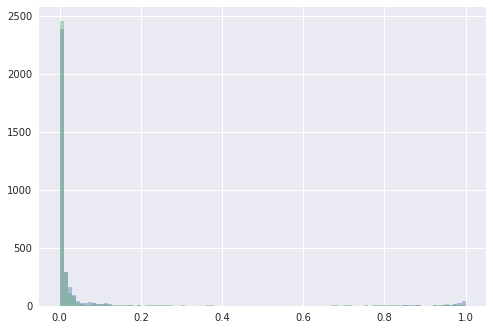

In [19]:
plt.style.use("seaborn")
for p in tdf.columns[tdf.columns.str.contains("pred")]:
    tdf[p].hist(bins=100, alpha=0.4)